#  Logistic Regression

Project Overview

This project demonstrates the process of creating a binary classification model with logistic regression to predict survey respondents who smoke cigarettes.


##What is Logistic Regression?

Logistic regression is a classification technique that gives the probabilistic output of dependent categorical values based on certain independent variables.

## Objectives

*   Build and evaluate a logistic regression model to classify smokers (1 = smoker, 0 = non-smoker) based on various predictors.
*   Data source: Population health-related survey dataset 


<h2>Table of Contents</h2>

<div class="alert alert-block alert-info" style="margin-top: 20px">
<ol>


1. [Import Data](#import)
2. [Model Pre-Processing](#mpp)
3. [Logistic Regression Model](#lrm)
4. [Model Accuracy Evaluation](#mae)
5. [Conclusions](#con)










## Import Data <a name="import"></a>


Import libraries:


In [1]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, auc, roc_curve, roc_auc_score, accuracy_score, classification_report 

Load the data and store it in dataframe `df`:


In [2]:
# Read in data and limit dataset to only columns of interest
url = "https://raw.githubusercontent.com/dandersonghub/Logistic_Regression/main/nhanes.csv"
df = pd.read_csv(url)


# Drop all columns below not included in model
df.drop(columns=['SEQN','ALQ110','ALQ130','WTINT2YR', 'SDMVPSU','SDMVSTRA','HIQ210'], inplace=True)


# Change column names for clarity
df.rename(columns={'BPXSY1':'SBP','BPXDI1':'DBP', 'RIDAGEYR': 'AGE', 'RIAGENDR':'GENDER','RIDRETH1': 'RACE', 
                   'DMDEDUC2':'EDUCATION', 'BMXBMI': 'BMI', 'BMXWT':'WEIGHT', 'SMQ020': 'CIGSMK'}, inplace=True)

df["CIGSMK"] = df.CIGSMK.replace({2: 0, 7: 0, 9: 0})

# Replace missings in "EDUCATION" column with most frequent value (4)
df["EDUCATION"].replace(np.nan, 4, inplace=True)

df

,ALQ101,CIGSMK,GENDER,AGE,RACE,DMDCITZN,EDUCATION,DMDMARTL,DMDHHSIZ,INDFMPIR,...,DBP,BPXSY2,BPXDI2,WEIGHT,BMXHT,BMI,BMXLEG,BMXARML,BMXARMC,BMXWAIST
0,1.0,1,1,62,3,1.0,5.0,1.0,2,4.39,...,70.0,124.0,64.0,94.8,184.5,27.8,43.3,43.6,35.9,101.1
1,1.0,1,1,53,3,2.0,3.0,3.0,1,1.32,...,88.0,140.0,88.0,90.4,171.4,30.8,38.0,40.0,33.2,107.9
2,1.0,1,1,78,3,1.0,3.0,1.0,2,1.51,...,46.0,132.0,44.0,83.4,170.1,28.8,35.6,37.0,31.0,116.5
3,2.0,0,2,56,3,1.0,5.0,6.0,1,5.00,...,72.0,134.0,68.0,109.8,160.9,42.4,38.5,37.7,38.3,110.1
4,2.0,0,2,42,4,1.0,4.0,3.0,5,1.23,...,70.0,114.0,54.0,55.2,164.9,20.3,37.4,36.0,27.2,80.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5730,2.0,1,2,76,3,1.0,3.0,2.0,1,1.43,...,48.0,112.0,46.0,59.1,165.8,21.5,38.2,37.0,29.5,95.0
5731,2.0,0,1,26,3,1.0,5.0,1.0,3,2.99,...,68.0,116.0,76.0,112.1,182.2,33.8,43.4,41.8,42.3,110.2
5732,1.0,1,2,80,3,1.0,4.0,2.0,1,2.97,...,56.0,146.0,58.0,71.7,152.2,31.0,31.3,37.5,28.8,NaN
5733,NaN,1,1,35,3,2.0,1.0,1.0,5,0.00,...,62.0,106.0,66.0,78.2,173.3,26.0,40.3,37.5,30.6,98.9


In [3]:
# Display all columns of interest and data types
# Predictor columns include demographic data such as age, race, gender, education, etc. 
# Predictor columns also include health related data such as body mass index, blood pressure, weight, etc.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5735 entries, 0 to 5734
Data columns (total 21 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ALQ101     5208 non-null   float64
 1   CIGSMK     5735 non-null   int64  
 2   GENDER     5735 non-null   int64  
 3   AGE        5735 non-null   int64  
 4   RACE       5735 non-null   int64  
 5   DMDCITZN   5734 non-null   float64
 6   EDUCATION  5735 non-null   float64
 7   DMDMARTL   5474 non-null   float64
 8   DMDHHSIZ   5735 non-null   int64  
 9   INDFMPIR   5134 non-null   float64
 10  SBP        5401 non-null   float64
 11  DBP        5401 non-null   float64
 12  BPXSY2     5535 non-null   float64
 13  BPXDI2     5535 non-null   float64
 14  WEIGHT     5666 non-null   float64
 15  BMXHT      5673 non-null   float64
 16  BMI        5662 non-null   float64
 17  BMXLEG     5345 non-null   float64
 18  BMXARML    5427 non-null   float64
 19  BMXARMC    5427 non-null   float64
 20  BMXWAIST

In [4]:
# Observe class imbalance 

df['CIGSMK'].value_counts()

0    3416
1    2319
Name: CIGSMK, dtype: int64

Dataset is imbalanced with 40.4% smokers and 59.6% non-smokers.

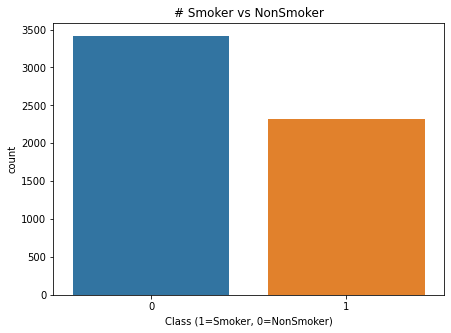

In [5]:
# Visualize class imbalance
f, ax = plt.subplots(figsize=(7, 5))
sns.countplot(x='CIGSMK', data=df)
_ = plt.title('# Smoker vs NonSmoker')
_ = plt.xlabel('Class (1=Smoker, 0=NonSmoker)')

## Model Pre-Processing <a name="mpp"></a>

In [6]:
# Put all independent variables into array for modeling 

X = np.asarray(df.loc[ : , df.columns != 'CIGSMK'])

# Impute all missing values (nan) in dataset with mean averages using SimpleImputer

F = SimpleImputer().fit_transform(X)

X=F

X[0:5]

array([[  1.  ,   1.  ,  62.  ,   3.  ,   1.  ,   5.  ,   1.  ,   2.  ,
          4.39, 128.  ,  70.  , 124.  ,  64.  ,  94.8 , 184.5 ,  27.8 ,
         43.3 ,  43.6 ,  35.9 , 101.1 ],
       [  1.  ,   1.  ,  53.  ,   3.  ,   2.  ,   3.  ,   3.  ,   1.  ,
          1.32, 146.  ,  88.  , 140.  ,  88.  ,  90.4 , 171.4 ,  30.8 ,
         38.  ,  40.  ,  33.2 , 107.9 ],
       [  1.  ,   1.  ,  78.  ,   3.  ,   1.  ,   3.  ,   1.  ,   2.  ,
          1.51, 138.  ,  46.  , 132.  ,  44.  ,  83.4 , 170.1 ,  28.8 ,
         35.6 ,  37.  ,  31.  , 116.5 ],
       [  2.  ,   2.  ,  56.  ,   3.  ,   1.  ,   5.  ,   6.  ,   1.  ,
          5.  , 132.  ,  72.  , 134.  ,  68.  , 109.8 , 160.9 ,  42.4 ,
         38.5 ,  37.7 ,  38.3 , 110.1 ],
       [  2.  ,   2.  ,  42.  ,   4.  ,   1.  ,   4.  ,   3.  ,   5.  ,
          1.23, 100.  ,  70.  , 114.  ,  54.  ,  55.2 , 164.9 ,  20.3 ,
         37.4 ,  36.  ,  27.2 ,  80.4 ]])

In [7]:
# Create array for outcome Smoker = 1, Non-Smoker =0

y = np.asarray(df['CIGSMK'])
y[0:5]

array([1, 1, 1, 0, 0])

In [8]:
#Normalize Data (scale values to a common range)

X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[-0.69839837, -1.03858157,  0.75681717, -0.03267685, -0.3771124 ,
         1.19315961, -0.7043875 , -0.76763488,  1.3109106 ,  0.16257113,
         0.0386901 , -0.04302422, -0.41795336,  0.62212634,  1.83136713,
        -0.22442537,  1.26334502,  2.36869835,  0.54404513,  0.09406643],
       [-0.69839837, -1.03858157,  0.26846715, -0.03267685,  1.65709502,
        -0.36360762,  0.16063037, -1.34750659, -0.71471045,  1.16630797,
         1.47872622,  0.83612327,  1.45813384,  0.41871623,  0.52447096,
         0.20110702, -0.15427506,  1.04725139,  0.01712772,  0.51137931],
       [-0.69839837, -1.03858157,  1.62499498, -0.03267685, -0.3771124 ,
        -0.36360762, -0.7043875 , -0.76763488, -0.58934628,  0.72020271,
        -1.88135806,  0.39654952, -1.98135937,  0.09510923,  0.39477897,
        -0.08258124, -0.79621623, -0.05395442, -0.41221239,  1.03915738],
       [ 1.37766255,  0.96285167,  0.43125049, -0.03267685, -0.3771124 ,
         1.19315961,  1.45815718, -1.34750659,  

## Create Train/Test Datasets

In [9]:
# Split data into test and train datasets to feed into LR model
# Testing set is 20%, Training 80%
from pandas.core.common import random_state
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)
print ('Train set:', X_train.shape, y_train.shape)
print ('Test set:', X_test.shape, y_test.shape)

Train set: (4588, 20) (4588,)
Test set: (1147, 20) (1147,)


## Logistic Regression Model <a name="lrm"></a>

In [10]:
# Create model and tune parameters
# Add custom weights in order to account for imbalanced data
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
weights= {0:40, 1:60}
LR = LogisticRegression(C=0.01, solver='liblinear', class_weight= weights).fit(X_train,y_train)
LR

LogisticRegression(C=0.01, class_weight={0: 40, 1: 60}, solver='liblinear')

In [11]:
# Obtain test predictions 
yhat = LR.predict(X_test)
yhat

array([1, 1, 0, ..., 0, 1, 0])

In [12]:
yhat.shape

(1147,)

In [13]:
# Get yhat prediction counts
pd.value_counts(yhat)

0    612
1    535
dtype: int64

Returns probability estimates for being a smoker. The first column are non-smokers (0), and the second column are smokers (1). 

In [14]:
# Obtain probability predictions for test data
yhat_prob = LR.predict_proba(X_test)
yhat_prob

array([[0.40305896, 0.59694104],
       [0.41319556, 0.58680444],
       [0.56371412, 0.43628588],
       ...,
       [0.92016826, 0.07983174],
       [0.31059622, 0.68940378],
       [0.69088621, 0.30911379]])

In [15]:
yhat_prob.shape

(1147, 2)

## Confusion Matrix 

In [21]:
# Classification Matrix Configuration and Plot

from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, yhat, labels=[1,0]))

[[319 151]
 [216 461]]


Confusion matrix, without normalization
[[319 151]
 [216 461]]


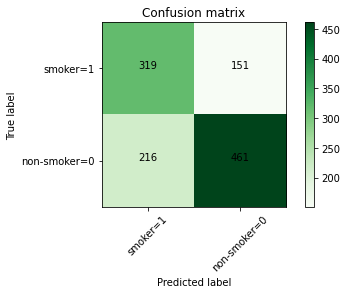

In [22]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['smoker=1','non-smoker=0'],normalize= False,  title='Confusion matrix')

In [18]:
tn, fp, fn, tp = cnf_matrix.ravel()
s = """
True Negatives: {3}
False Positives {2}
False Negatives {1}
True Positives {0}
""".format(tn, fp, fn, tp)

print(s)


True Negatives: 461
False Positives 216
False Negatives 151
True Positives 319



The confusion matrix visually displays the binary classifier's ability to correctly predict the classes (1=smoker, 0=nonsmoker). Out of 1,147 test respondents, the classifier correctly predicted 319 as 1 but incorrectly predicted 151 as 0. The classifier correctly predicted 461 as 0, and 216 of them incorrectly as 1.

## Model Accuracy Evaluation <a name="mae"></a>

## Classification Report 

The metrics below can be used to help understand how well our model is able to predict those who smoke.

$Precision$ = $Positive$ $Predictive$ $Value$ = $\frac{TP}{TP + FP}$

$Recall$ = $Sensitivity$ = $True$ $Positive$ $Rate$ = $\frac{TP}{TP + FN}$

$Accuracy$ =  $\frac{TP + TN}{TP + TN + FP + FN}$

$F1-Score$ = Average of Precision and Recall, the closer to 1, the better the model.  

In [19]:
print (classification_report(y_test, yhat, target_names=['nonsmoker', 'smoker']))

              precision    recall  f1-score   support

   nonsmoker       0.75      0.68      0.72       677
      smoker       0.60      0.68      0.63       470

    accuracy                           0.68      1147
   macro avg       0.67      0.68      0.68      1147
weighted avg       0.69      0.68      0.68      1147



**Precision:** Out of all the people that the model predicted would be a smoker, only 60% were.

**Recall:** Out of all the people who were true smokers, the model only predicted this outcome correctly for 67% of those people.

**F1-score:** A smoker F1-score of 0.63 tells us that the model does a moderate job of predicting whether or not people will be a smoker. 

The average accuracy for this logistic regression classifier is 68%. The ideal model would have significantly higher accuracy.

## ROC/AUC

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


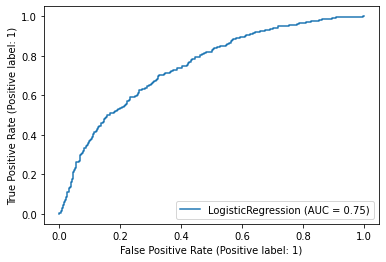

In [20]:
# Plot ROC/AUC (visualizes model performance)
# Percentage of correct predictions

from sklearn.metrics._plot.roc_curve import plot_roc_curve
disp = plot_roc_curve(LR, X_test, y_test)

Based on the ROC curve and AUC value of 0.75, this classifier has a 75% chance of segregating the binary classes correctly. 

Note: A model with an AUC score of 0.5 is no better than a model that performs random guessing.

## Conclusions <a name="con"></a>

A logistic regression classification model was built to predict the binary smoking outcome based on 20 health-related predictor variables. These variables were normalized to scale them to a common range for modeling. There was a class imbalanced observed in the dataset and the class weight adjustment technique was utilized to account for this.

The confusion matrix visually displays the binary classifier's ability to correctly predict the classes (1=smoker, 0=nonsmoker). Out of all the people that the model predicted would be a smoker, only 60% were. Out of all the people who were true smokers, the model only predicted this outcome correctly for 67% of those people. The average accuracy for this logistic regression classifier is 68%.

Based on the accuracy (68%) and ROC/AUC (0.75) of this classifier, I recommend further modeling to obtain higher accuracy. Next steps would include comparing additional classifiers to see which one would perform better on our test data. In addition to trying another classification algorithm, oversampling/under sampling, decision threshold moving, and other parameter tuning can also be utilized to improve model performance.


